In [1]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

Welcome to JupyROOT 6.16/00


In [2]:
import sys
print(sys.version)

3.6.5 (default, Feb 13 2019, 15:14:38) 
[GCC 6.2.0]


In [3]:
import matplotlib as mpl
mpl.style.use('seaborn-bright')

In [17]:
web_dir = '/publicweb/a/as2872/iDMPlots/trigger_MET120_2018_MC'

# Define functions

In [4]:
def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = []
    yy = []
    yl = []
    yu = []
    for i in range(1, nBins+1):
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 0 and eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)) == 1.: continue
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 1. and eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) == 1.: continue
        
        xx.append(tot.GetXaxis().GetBinCenter(i))
        yy.append(eff.GetEfficiency(eff.GetGlobalBin(i)))
        yl.append(eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)))
        yu.append(eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)))
                  
    
    return {'x': np.array(xx),
            'y': np.array(yy),
            'yerr': np.array([yl, yu])}

In [5]:
import scipy.special
from scipy.optimize import curve_fit, fsolve
from scipy import odr

def fsigmoid(z, p0, p1):
    return 1.0 / (1.0 + np.exp(-p0*(z-p1)))
def ferf_cf(z, p0, p1, p2, p3):
    return p2 + p3*scipy.special.erf((z-p0)/p1)
def f98percentile_cf(z, p):
    return ferf_cf(z, *p) - (p[2]+p[3])*0.98
def ferf_odr(p, z):
    return p[2] + p[3]*scipy.special.erf((z-p[0])/p[1])
def f98percentile_odr(z, p):
    return ferf_odr(p, z) - (p[2]+p[3])*0.98

def make_plot(ax, sample, objs, variable, plot_props, event_selection='df'):
    h0 = ROOT.TH1F(f'h0_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    h1 = ROOT.TH1F(f'h1_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    for l,x in objs[event_selection][variable].iteritems():
        h0.Fill(x)
    for l,x in objs[event_selection].query('fired==True')[variable].iteritems():
        h1.Fill(x)
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)
    ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'], 
                label=f'{props["label"]}', markersize=3, alpha=0.3, fmt='o', c=objs['color'])
    
    selection_string = 'pre-selected events' if event_selection == 'df' else 'all events'
    ax.set_title(f'Trigger efficiency as a function of MET (over {selection_string})')
    ax.set_xlabel('MET pT [GeV]')
    ax.set_ylabel('Trigger efficiency')
    ax.set_ylim((0,1))
    
    return data

def make_plot_fit_cf(ax, sample, objs, variable, plot_props, event_selection='df'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    popt, pcov = curve_fit(ferf_cf, data['x'][minbin:maxbin], data['y'][minbin:maxbin], sigma=data['yerr'][1][minbin:maxbin],
                           bounds=([50,0,-10,-10],[250,100,10,10]))
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {pcov[i,i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_cf, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_cf(fit_range, *popt), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    ax.legend()
    
def make_plot_fit_odr(ax, sample, objs, variable, plot_props, event_selection='df'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    
    model = odr.Model(ferf_odr)
    xerror = np.repeat(data['x'][1]-data['x'][0], len(data['x'])-minbin)
    real_data = odr.RealData(data['x'][minbin:maxbin], data['y'][minbin:maxbin], sx=xerror, sy=data['yerr'][0][minbin:maxbin])
    odr_obj = odr.ODR(real_data, model, beta0=[132, 36, 0.5, 0.5])
    out = odr_obj.run()
    
    popt = out.beta
    perr = out.sd_beta
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {perr[i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_odr, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_odr(popt, fit_range), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    
    ax.legend()

# Load data

In [6]:
redirector = 'root://cmseos.fnal.gov/'
basedir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/trigger_efficiency'
samples = {
    '5p25': {
        'filename': redirector + basedir + '/trigger_Mchi-5p25_dMchi-0p5_ctau-100_v2.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.1$',
        'color': 'C0'
    },
    '52p5': {
        'filename': redirector + basedir + '/trigger_Mchi-52p5_dMchi-5p0_ctau-100.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.1$',
        'color': 'C1'
    },
    '6p0': {
        'filename': redirector + basedir + '/trigger_Mchi-6p0_dMchi-2p0_ctau-100.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.4$',
        'color': 'C2'
    },
    '60p0': {
        'filename': redirector + basedir + '/trigger_Mchi-60p0_dMchi-20p0_ctau-100.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.4$',
        'color': 'C3'
    },
}

In [7]:
for sample, objs in samples.items():
    file = uproot.open(objs['filename'])
    objs['trig_tree'] = file['TRIG_dsa_HLT_PFMET120_PFMHT120/trigEffiForMuTrack']
    objs['selftrig_tree'] = file['TRIGself_dsa_HLT_PFMET120_PFMHT120/trigSelfEffiForMuTrack']
    objs['df'] = objs['trig_tree'].pandas.df()
    objs['self_df'] = objs['selftrig_tree'].pandas.df()

In [15]:
_dict = {}
for sample, props in samples.items():
    _counts = props['df'].groupby('entry').nth(0)['fired'].value_counts()
    _dict[sample] = {}
    _dict[sample]['num_total'] = props['self_df'].groupby('entry').nth(0)['fired'].value_counts().sum()
    _dict[sample]['num_select'] = _counts.sum()
    _dict[sample]['num_trig'] = _counts.iloc[0]
    _dict[sample]['trig_over_total'] = _counts.iloc[0] / _dict[sample]['num_total']
    _dict[sample]['trig_over_select'] = _counts.iloc[0] / _counts.sum()
    
pd.options.display.float_format = '{:,.2f}'.format
df = pd.DataFrame(_dict)
cols = ['num_total', 'num_select', 'num_trig', 'trig_over_total', 'trig_over_select']
df = df.transpose()[cols].transpose()
df.to_csv(web_dir + '/trigger_cutflow.csv')
df

,5p25,52p5,6p0,60p0
num_total,"52,147.00","145,551.00","41,889.00","135,508.00"
num_select,"1,282.00","10,163.00","6,078.00","35,081.00"
num_trig,800.00,"7,281.00","3,110.00","20,157.00"
trig_over_total,0.02,0.05,0.07,0.15
trig_over_select,0.62,0.72,0.51,0.57


# Comparison of triggered vs pre-selected distributions with Coffea

In [132]:
from coffea import hist

In [133]:
dataset_axis = hist.Cat("eventtype", "")

muon_pt_axis = hist.Bin("mu_pt", r"Leding muon $p_T$ [GeV]", 10, 0, 30)
muon_eta_axis = hist.Bin("mu_eta", r"Leading muon eta", 10, -2.5, 2.5)
muon_phi_axis = hist.Bin("mu_phi", r"Leading muon phi", 10, -3.3, 3.3)
jet_pt_axis = hist.Bin("jet_pt", r"Leding jet $p_T$ [GeV]", 10, 0, 500)
jet_eta_axis = hist.Bin("jet_eta", r"Leading jet eta", 10, -2.5, 2.5)
jet_phi_axis = hist.Bin("jet_phi", r"Leading jet phi", 10, -3.3, 3.3)
met_pt_axis = hist.Bin("met_pt", r"MET $p_T$ [GeV]", 10, 0, 500)
met_phi_axis = hist.Bin("met_eta", r"MET phi", 10, -3.3, 3.3)

In [134]:
coffea_axes = {
    'mu_pt': {
        'axis_object': muon_pt_axis,
        'df_column': 'pt',
        'slice': (slice(None), 0)
    },
    'mu_eta': {
        'axis_object': muon_eta_axis,
        'df_column': 'eta',
        'slice': (slice(None), 0)
    },
    'mu_phi': {
        'axis_object': muon_phi_axis,
        'df_column': 'phi',
        'slice': (slice(None), 0)
    },
    'jet_pt': {
        'axis_object': jet_pt_axis,
        'df_column': 'recoJetPt',
        'slice': (slice(None))
    },
    'jet_eta': {
        'axis_object': jet_eta_axis,
        'df_column': 'recoJetEta',
        'slice': (slice(None))
    },
    'jet_phi': {
        'axis_object': jet_phi_axis,
        'df_column': 'recoJetPhi',
        'slice': (slice(None))
    },
    'met_pt': {
        'axis_object': met_pt_axis,
        'df_column': 'recoPFMetPt',
        'slice': (slice(None))
    },
}

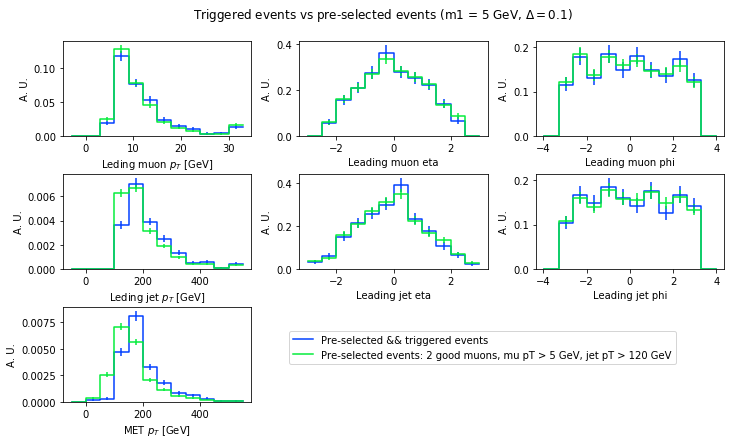

In [138]:
sample = '5p25'

fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle(f'Triggered events vs pre-selected events ({samples[sample]["label"]})')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
axes[2,1].axis('off')
axes[2,2].axis('off')

for index, (key, info) in enumerate(coffea_axes.items()):
    ax = axes[index//3, index%3]
    
    df = samples[sample]['trig_tree'].arrays('*', namedecode="utf-8")
    
    myhist = hist.Hist("A. U.", dataset_axis, info['axis_object'])
    kwargs = { key: df[info['df_column']][info['slice']] }
    myhist.fill(eventtype='Pre-selected events: 2 good muons, mu pT > 5 GeV, jet pT > 120 GeV', **kwargs)
    kwargs = { key: df[info['df_column']][df['fired']][info['slice']] }
    myhist.fill(eventtype='Pre-selected && triggered events', **kwargs)
    
    hist.plot1d(myhist, overlay='eventtype', density=True, ax=ax, clear=False, overflow='all')
    ax.set_ylim(bottom=0)
    
    
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels[0:2], handles[0:2]))
ax.legend(by_label.values(), by_label.keys(), loc=(1.2,0.4));

# fig.savefig(f'{web_dir}/shape_comparison_preselected_{sample}.png', bbox_inches='tight')

# Comparison of triggered vs pre-selected distributions without Coffea

In [11]:
eff_plots = OrderedDict({
    'pt': {
        'axis': np.array(np.append(np.arange(5,22,3), [30]), dtype='float64'),
        'range': [0, 30],
        'label': 'Leading muon pT [GeV]'
    },
    'eta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading muon eta'
    },
    'phi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading muon phi'
    },
    'recoJetPt': {
        'axis': np.array(np.arange(30,300,30), dtype='float64'),
        'range': [0, 500],
        'label': 'Leading jet pT [GeV]'
    },
    'recoJetEta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading jet eta'
    },
    'recoJetPhi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading jet phi'
    },
    'recoPFMetPt': {
        'axis': np.array(np.arange(30,300,30), dtype='float64'),
        'range': [0, 500],
        'label': 'MET pT [GeV]'
    },
})
#     'recoPFMetPhi': {
#         'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
#         'label': 'MET phi'
#     },

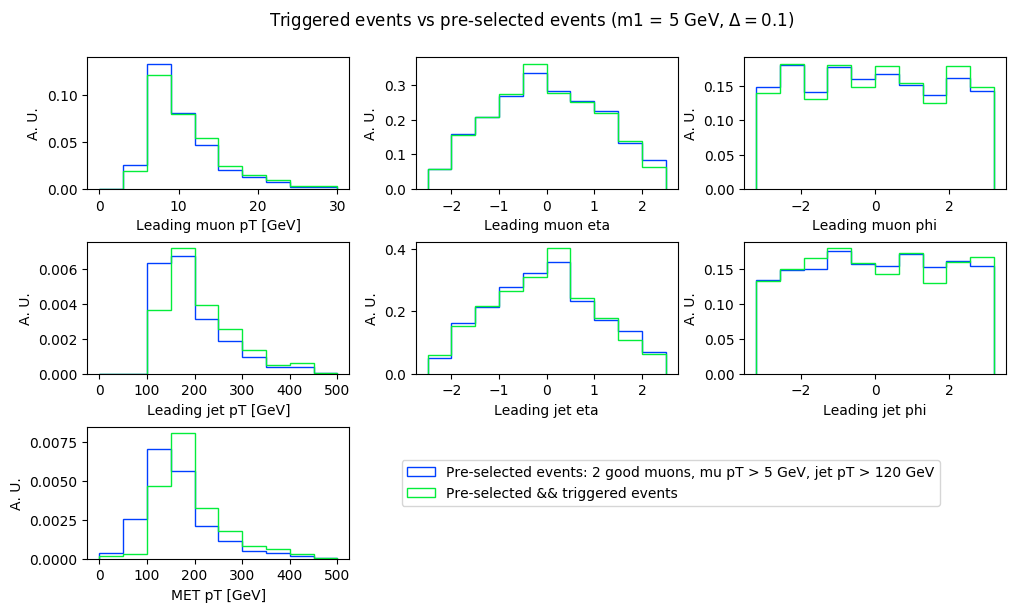

In [135]:
sample = '5p25'

fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle(f'Triggered events vs pre-selected events ({samples[sample]["label"]})')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
axes[2,1].axis('off')
axes[2,2].axis('off')

for index, (column, props) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = props['axis']
    kwargs = {'range': props['range'], 'bins':10, 'density': True, 'histtype':'step'}
    
    df = samples[sample]['df']
    ax.hist(df[column].groupby('entry').nth(0), **kwargs, 
            label='Pre-selected events: 2 good muons, mu pT > 5 GeV, jet pT > 120 GeV');
    ax.hist(df.query('fired==True')[column].groupby('entry').nth(0), **kwargs, 
            label='Pre-selected && triggered events');
    ax.set_xlabel(props['label'])
    ax.set_ylabel('A. U.')

ax.legend(loc=(1.2 ,0.4))

# Trigger efficiency of `MET_120` vs kinematic variables -- pre-selected events

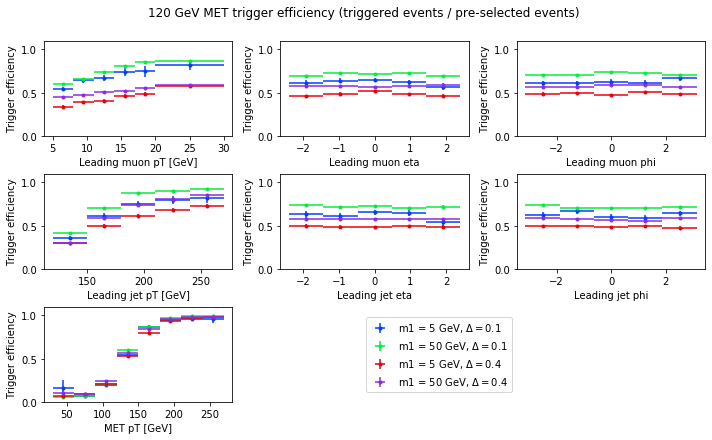

In [140]:
fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle('120 GeV MET trigger efficiency (triggered events / pre-selected events)')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
axes[2,1].axis('off')
axes[2,2].axis('off')

for index, (column, properties) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = properties['axis']
    
    for sample, objs in samples.items():
    
        if 'h0' in locals():
            del h0,h1
    
        h0 = ROOT.TH1F(f'h0_1', '', len(bin_edges)-1, bin_edges)
        h1 = ROOT.TH1F(f'h1_1', '', len(bin_edges)-1, bin_edges)

        for l,x in objs['df'][column].groupby('entry').nth(0).iteritems():
            h0.Fill(x)
        for l,x in objs['df'].query('fired==True')[column].groupby('entry').nth(0).iteritems():
            h1.Fill(x)

        eff = ROOT.TEfficiency(h1, h0)
        data = extract_teffi(eff)
    
        if column == 'pt':
            xerr=np.diff(bin_edges)/2
        else:
            xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)

        ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'],
                    fmt='o', label=f'{objs["label"]}', ms=3, c=objs['color'])
        ax.set_xlabel(properties['label'])
        ax.set_ylabel('Trigger efficiency')
        ax.set_ylim(0,1.1)
        
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(-0.8,0.1));

# fig.savefig(f'{web_dir}/trigger_eff_preselected.png', bbox_inches='tight')

[m1 = 5 GeV, $\Delta = 0.1$]
fit parameter 1-sigma error
———————————–
132.19 +- 1.20
36.88 +- 3.25
0.51 +- 0.00
0.45 +- 0.00

[m1 = 50 GeV, $\Delta = 0.1$]
fit parameter 1-sigma error
———————————–
130.27 +- 4.00
41.55 +- 9.01
0.51 +- 0.00
0.48 +- 0.00

[m1 = 5 GeV, $\Delta = 0.4$]
fit parameter 1-sigma error
———————————–
135.22 +- 2.59
45.03 +- 9.36
0.52 +- 0.00
0.45 +- 0.00

[m1 = 50 GeV, $\Delta = 0.4$]
fit parameter 1-sigma error
———————————–
132.40 +- 0.85
43.19 +- 2.73
0.53 +- 0.00
0.45 +- 0.00



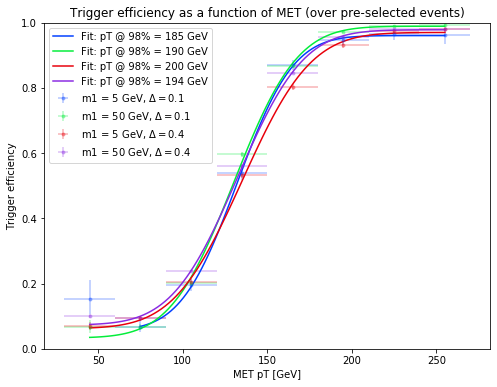

In [125]:
# Using cf (curve_fit), no x or y errors in the fit

fig, ax = plt.subplots(figsize=(8,6))
for index, (sample, props) in enumerate(samples.items()):
    make_plot_fit_cf(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='df')

# fig.savefig('/publicweb/a/as2872/iDMPlots/trigger_MET120_2018_MC/trigger_vs_met_fit_preselected.png', bbox_inches='tight')

[m1 = 5 GeV, $\Delta = 0.1$]
fit parameter 1-sigma error
———————————–
132.17 +- 2.88
41.19 +- 3.16
0.50 +- 0.01
0.46 +- 0.01

[m1 = 50 GeV, $\Delta = 0.1$]
fit parameter 1-sigma error
———————————–
136.24 +- 3.54
36.99 +- 3.55
0.53 +- 0.00
0.46 +- 0.00

[m1 = 5 GeV, $\Delta = 0.4$]
fit parameter 1-sigma error
———————————–
137.59 +- 1.47
47.47 +- 1.82
0.52 +- 0.00
0.46 +- 0.00

[m1 = 50 GeV, $\Delta = 0.4$]
fit parameter 1-sigma error
———————————–
140.07 +- 9.51
33.23 +- 10.35
0.54 +- 0.00
0.44 +- 0.00



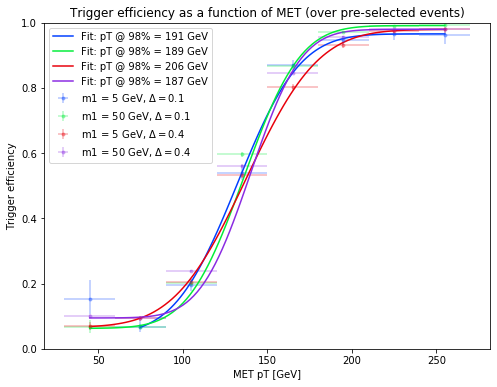

In [130]:
# Using ODR, includes both x errors (bin width) and y errors

fig, ax = plt.subplots(figsize=(8,6))
for index, (sample, props) in enumerate(samples.items()):
    make_plot_fit_odr(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='df')

# fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected.png', bbox_inches='tight')

# Trigger efficiency of `MET_120`  vs kinematic distributions -- all events

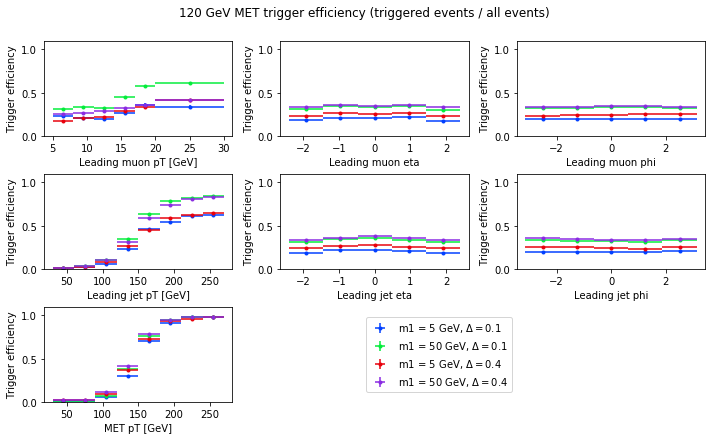

In [142]:
fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle('120 GeV MET trigger efficiency (triggered events / all events)')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
axes[2,1].axis('off')
axes[2,2].axis('off')

for index, (column, properties) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = properties['axis']
    
    for sample, objs in samples.items():
    
        if 'h0' in locals():
            del h0,h1
    
        h0 = ROOT.TH1F(f'h0_1', '', len(bin_edges)-1, bin_edges)
        h1 = ROOT.TH1F(f'h1_1', '', len(bin_edges)-1, bin_edges)

        for l,x in objs['self_df'][column].groupby('entry').nth(0).iteritems():
            h0.Fill(x)
        for l,x in objs['self_df'].query('fired==True')[column].groupby('entry').nth(0).iteritems():
            h1.Fill(x)

        eff = ROOT.TEfficiency(h1, h0)
        data = extract_teffi(eff)
    
        if column == 'pt':
            xerr=np.diff(bin_edges)/2
        else:
            xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)

        ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'],
                    fmt='o', label=f'{objs["label"]}', ms=3, c=objs['color'])
        ax.set_xlabel(properties['label'])
        ax.set_ylabel('Trigger efficiency')
        ax.set_ylim(0,1.1)
        
# fig.legend(loc=(0.6,0.1), title='Samples')
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(-0.8,0.1))

# fig.savefig(f'{web_dir}/trigger_eff_all.png', bbox_inches='tight')

[m1 = 5 GeV, $\Delta = 0.1$]
fit parameter 1-sigma error
———————————–
151.94 +- 1.56
39.85 +- 1.39
0.50 +- 0.00
0.49 +- 0.00

[m1 = 50 GeV, $\Delta = 0.1$]
fit parameter 1-sigma error
———————————–
144.69 +- 0.61
39.76 +- 0.57
0.49 +- 0.00
0.49 +- 0.00

[m1 = 5 GeV, $\Delta = 0.4$]
fit parameter 1-sigma error
———————————–
146.69 +- 1.39
38.17 +- 1.26
0.49 +- 0.00
0.47 +- 0.00

[m1 = 50 GeV, $\Delta = 0.4$]
fit parameter 1-sigma error
———————————–
143.07 +- 1.39
39.98 +- 1.35
0.50 +- 0.00
0.48 +- 0.00



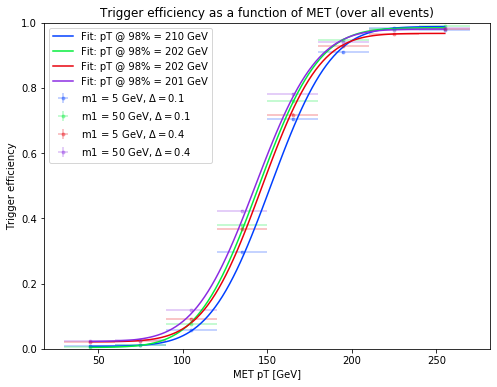

In [131]:
# Using ODR for fit with errors included 

fig, ax = plt.subplots(figsize=(8,6))
for index, (sample, props) in enumerate(samples.items()):
    make_plot_fit_odr(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='self_df')

# fig.savefig(f'{web_dir}/trigger_vs_met_fit_all.png', bbox_inches='tight')